# Data Analysis Tools
# Assignment: Testing a Potential Moderator

Following is the Python program I wrote to fulfill the last assignment of the [Data Analysis Tools online course](https://www.coursera.org/learn/data-analysis-tools/home/welcome).

I used [Jupyter Notebook](http://nbviewer.jupyter.org/github/ipython/ipython/blob/3.x/examples/Notebook/Index.ipynb) as it is a pretty way to write code and present results.

## Research question for this assignment

Using the [Gapminder database](http://www.gapminder.org/), I found a significant [correlation](PearsonCorrelation.ipynb) between the income per person (the explanatory variable) and the residential electricity consumption (the response variable). For this exercice, I would like to see if the urban rate is a potential moderator.

## Data management

For the question I'm interested in, the countries for which data are missing will be discarded. As missing data in Gapminder database are replace directly by `NaN` no special data treatment is needed.

In [1]:
# Magic command to insert the graph directly in the notebook
%matplotlib inline
# Load a useful Python libraries for handling data
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

In [2]:
# Read the data
data_filename = r'gapminder.csv'
data = pd.read_csv(data_filename, low_memory=False)
data = data.set_index('country')

General information on the Gapminder data

In [3]:
display(Markdown("Number of countries: {}".format(len(data))))
display(Markdown("Number of variables: {}".format(len(data.columns))))

Number of countries: 213

Number of variables: 15

In [4]:
subdata2 = (data[['incomeperperson', 'urbanrate', 'relectricperperson']]
                .assign(income=lambda x: pd.to_numeric(x['incomeperperson'], errors='coerce'),
                        urbanrate=lambda x: pd.to_numeric(x['urbanrate'], errors='coerce'),
                        electricity=lambda x: pd.to_numeric(x['relectricperperson'], errors='coerce'))
                .dropna())

## Data analysis

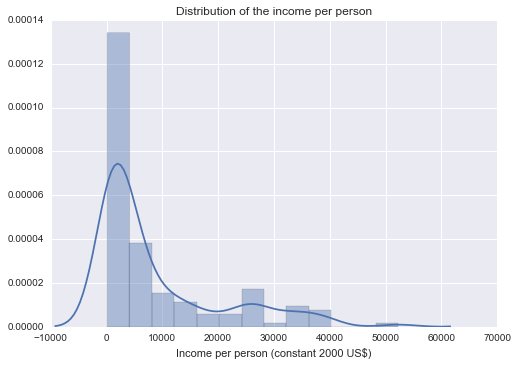

In [5]:
sns.distplot(subdata2.income)
plt.xlabel("Income per person (constant 2000 US$)")
_ = plt.title("Distribution of the income per person")

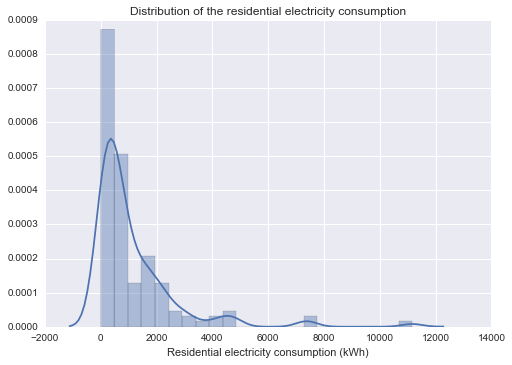

In [6]:
sns.distplot(subdata2.electricity)
plt.xlabel("Residential electricity consumption (kWh)")
_ = plt.title("Distribution of the residential electricity consumption")

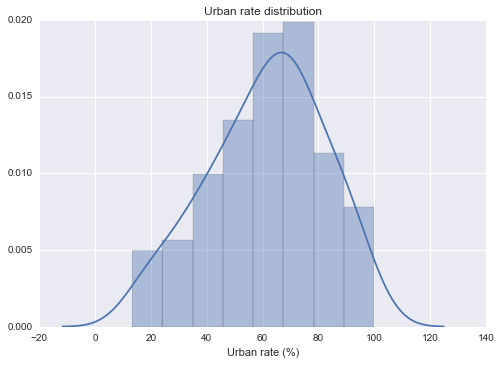

In [7]:
sns.distplot(subdata2.urbanrate)
plt.xlabel("Urban rate (%)")
_ = plt.title("Urban rate distribution")

## Correlation test

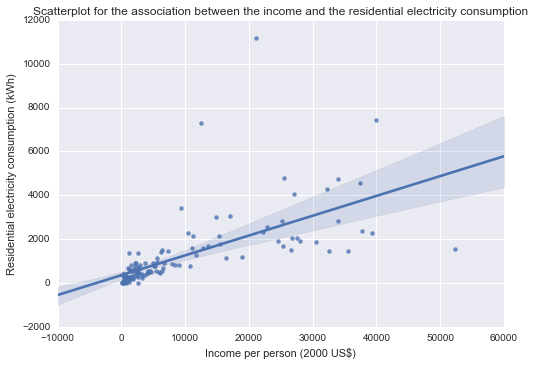

In [8]:
sns.regplot(x='income', y='electricity', data=subdata2)
plt.xlabel('Income per person (2000 US$)')
plt.ylabel('Residential electricity consumption (kWh)')
_ = plt.title('Scatterplot for the association between the income and the residential electricity consumption')

In [9]:
correlation, pvalue = stats.pearsonr(subdata2['income'], subdata2['electricity'])

display(Markdown("The correlation coefficient is {:.3g} and the associated p-value is {:.3g}.".format(correlation, pvalue)))
display(Markdown("And the coefficient of determination is {:.3g}.".format(correlation**2)))

The correlation coefficient is 0.652 and the associated p-value is 4.63e-17.

And the coefficient of determination is 0.425.

The Pearson test proves a significant positive relationship between income per person and residential electricity consumption as the p-value is below 0.05.

Moreover, the square of the correlation coefficient, i.e. the coefficient of determination, is 0.425. This means that we can predict 42.5% of the variability of residential electricity consumption knowing the income per person.

## Potential moderator

Now comes the analysis of Pearson correlation between different urban rate group to see if the urban rate is a moderator on the relationship between income per person and residential electricity consumption.

In [10]:
def urban_group(row):
    if row['urbanrate'] < 25.0:
        return '0%<=..<25%'
    elif row['urbanrate'] < 50.0:
        return '25%<=..<50%'
    elif row['urbanrate'] < 75.0:
        return '50%<=..<75%'
    else:
        return '75%=<'
    
subdata3 = subdata2.copy()
subdata3['urban_group'] = pd.Categorical(subdata3.apply(lambda x: urban_group(x), axis=1))

In [11]:
summary = dict()
for group in subdata3.urban_group.cat.categories:
    moderator_group = subdata3[subdata3['urban_group'] == group]
    summary[group] = stats.pearsonr(moderator_group['income'], moderator_group['electricity'])
    
df = (pd.DataFrame(summary)
        .rename(index={0:'Pearson r', 1:'p-value'}))

In [12]:
df2 = (df.stack()
         .unstack(level=0))
df2.index.name = 'Urban rate'
df2

,Pearson r,p-value
Urban rate,,
0%<=..<25%,0.998985,6.308143e-08
25%<=..<50%,0.826256,1.034958e-08
50%<=..<75%,0.794745,9.499779e-14
75%=<,0.377964,2.752877e-02


For all urban rate categories, the p-value is below the threshold of 0.05. Therefore the urban rate does not moderate the relationship between income per person and residential electricity consumption. In other words the residential electricity consumption has a significant positive relationship in regard to the income per person whatever the urban rate in the country.

By plotting the scatter plots of the four groups, we can see that the correlation is indeed present for all of them. One corollary finding from the graphics below is the tendency of countries with higher income per person to have higher urban rate.

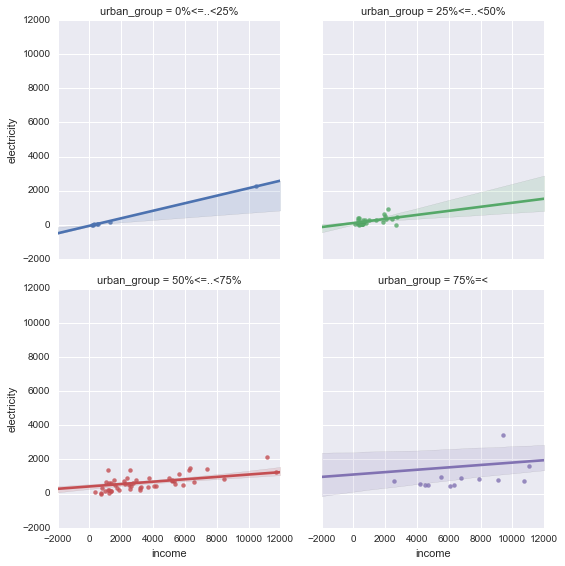

In [13]:
g = sns.FacetGrid(subdata3.reset_index(),
                  col='urban_group', hue='urban_group', col_wrap=2, size=4)
_ =g.map(sns.regplot, 'income', 'electricity')



This conclude the final assignment of this second course.

> If you are interested into data sciences, follow me on [Tumblr](http://fcollonval.tumblr.com/).